## Additional experiments

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from coba.experiments  import Experiment, Result
from coba.environments import Environments
from coba.learners     import (RandomLearner,
                               EpsilonBanditLearner,
                               VowpalEpsilonLearner,
                               VowpalRegcbLearner,
                               VowpalSquarecbLearner,
                               LinUCBLearner)

from learners import (IGWBanditLearner,
                      SemiparametricIGWBanditLearner, MNA_SIGWBanditLearner)

## Step-wise linear reward, linear treatment effect, no model selection

- Number of arms: 2
- Number of features: 10
- Number of interactions: 10000
- Std dev: 1/10
- Contexts are sampled from a unit sphere.
- Arm treatment effects (g): Linear.
- nuisance function (h): 0 if context[0]>0.25; negative highest g(x,.) otherwise.
- Feature selection: False

2022-10-13 01:52:01 -- Processing chunk...
2022-10-13 01:52:01 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-10-13 01:52:01 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-10-13 01:52:01 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-10-13 01:52:02 --   * Loading LambdaSimulation... (0.96 seconds) (completed)
2022-10-13 01:52:02 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-10-13 01:52:02 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-10-13 01:52:02 --   * Evaluating Learner 0 on Environment 0... (0.22 seconds) (completed)
2022-10-13 01:52:05 --   * Evaluating Learner 1 on Environment 0... (3.0 seconds) (completed)
2022-10-13 01:52:10 --   * Evaluating Learner 2 on Environment 0... (4.94 seconds) (completed)
2022-10-13 01:52:11 --   * Loading LambdaSimulation... (0.83 seconds) (completed)
2022-10-13 01:52:11 --   * Creating Environment 1 from Load

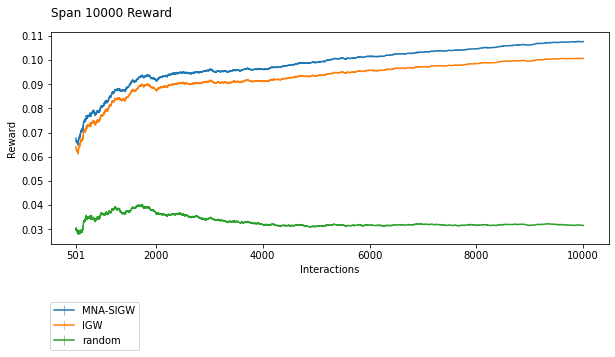

In [4]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 10
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = .5 * (np.dot(theta, np.array(context)) + 1)
    h = 0. 
        
    if context[0] > .25:
        h += 0
    else:
        h += -np.max(v)

    g = v[np.argmax(action)]   
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = False
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)]

os.remove("./data/paper-experiment-3.log")
result = Experiment(environments, learners).evaluate("./data/paper-experiment-3.log")
result.plot_learners(sort="reward", span=n_interactions)

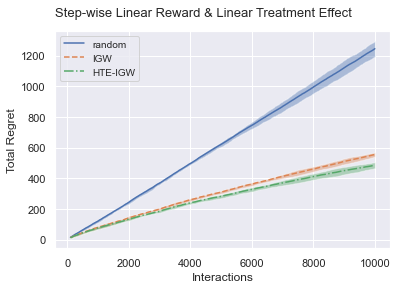

In [5]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-3.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "IGW", "HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i%len(ls)])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Step-wise Linear Reward & Linear Treatment Effect", loc='left', pad=15, fontsize=13)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-3.png', dpi=300)

## Step-wise linear reward, linear treatment effect, model selection

- Number of arms: 2
- Number of features: 100
- Number of interactions: 10000
- Std dev: 1/10
- Contexts are sampled from a unit sphere.
- Arm treatment effects (g): Linear.
- nuisance function (h): 0 if context[0]>0.25; negative highest g(x,.) otherwise.
- Feature selection: True

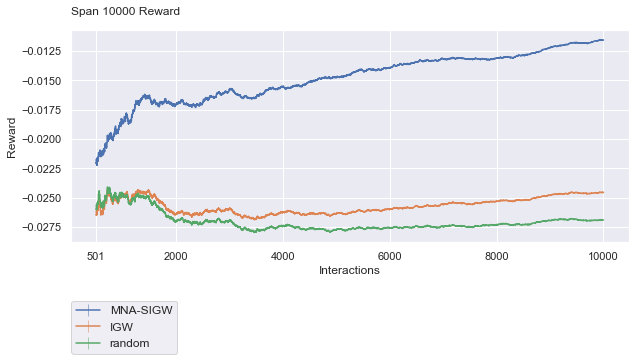

In [24]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = .5 * (np.dot(theta, np.array(context)) + 1)
    h = 0. 
        
    if context[0] > .25:
        h += 0
    else:
        h += -np.max(v)

    g = v[np.argmax(action)] 
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = True
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)]

# os.remove("./data/paper-experiment-4.log")
result = Experiment(environments, learners).evaluate("./data/paper-experiment-4.log")
result.plot_learners(sort="reward", span=n_interactions)

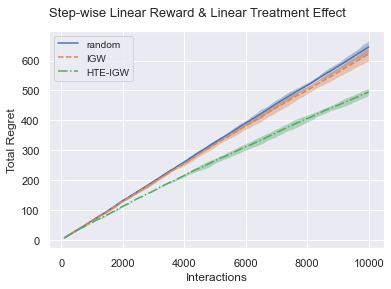

In [26]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-4.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "IGW", "HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i%len(ls)])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Step-wise Linear Reward & Linear Treatment Effect", loc='left', pad=15, fontsize=13)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-4.png', dpi=300)

## Linear reward, constant treatment effect, no model selection

- Number of arms: 2
- Number of features: 100
- Number of interactions: 10000
- Std dev: 1/10
- Contexts are sampled from a unit sphere.
- Arm treatment effects (g): constant for all arms.
- Nusance function (h): Linear.
- Feature selection: False

2022-10-13 02:09:03 -- Processing chunk...
2022-10-13 02:09:04 --   * Loading LambdaSimulation... (0.72 seconds) (completed)
2022-10-13 02:09:04 --   * Creating Environment 1 from Loaded Source... (0.0 seconds) (completed)
2022-10-13 02:09:25 --   * Evaluating Learner 1 on Environment 1... (20.94 seconds) (completed)
2022-10-13 02:09:52 --   * Evaluating Learner 2 on Environment 1... (27.48 seconds) (completed)
2022-10-13 02:09:53 --   * Loading LambdaSimulation... (0.73 seconds) (completed)
2022-10-13 02:09:53 --   * Creating Environment 2 from Loaded Source... (0.01 seconds) (completed)
2022-10-13 02:09:53 --   * Recording Environment 2 statistics... (0.01 seconds) (completed)
2022-10-13 02:09:54 --   * Evaluating Learner 0 on Environment 2... (0.21 seconds) (completed)
2022-10-13 02:10:16 --   * Evaluating Learner 1 on Environment 2... (22.84 seconds) (completed)
2022-10-13 02:10:45 --   * Evaluating Learner 2 on Environment 2... (28.38 seconds) (completed)
2022-10-13 02:10:45 --   

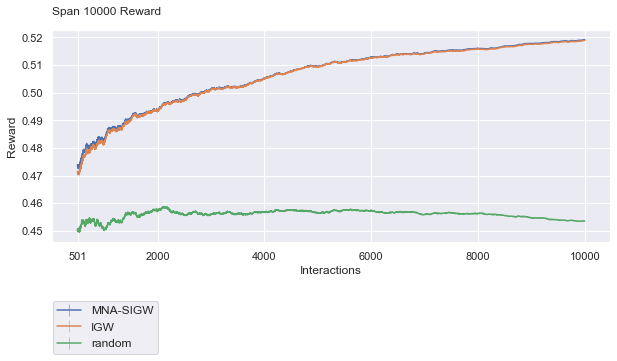

In [13]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_context_features))
theta = theta / np.linalg.norm(theta)

onehot = np.zeros(n_actions)
onehot[0] = 1
rs = .25 * (np.random.uniform(size=(n_actions)) + onehot)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    h = .25 * (np.dot(theta, np.array(context)) + 1)
    g = rs[np.argmax(action)]
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = False
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)
               ]

# os.remove("./data/paper-experiment-5.log")
result = Experiment(environments, learners).evaluate("./data/paper-experiment-5.log")
result.plot_learners(sort="reward", span=n_interactions)

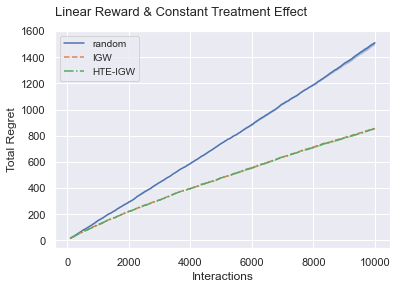

In [14]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-5.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "IGW", "HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Linear Reward & Constant Treatment Effect", loc='left', pad=15, fontsize=13)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-5.png', dpi=300)

## Step-wise linear + perturbed linear treatment effect, model selection

2022-11-30 20:28:18 -- Processing chunk...
2022-11-30 20:28:18 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-11-30 20:28:18 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-11-30 20:28:18 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-11-30 20:28:20 --   * Loading LambdaSimulation... (1.7 seconds) (completed)
2022-11-30 20:28:20 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-11-30 20:28:20 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-11-30 20:28:21 --   * Evaluating Learner 0 on Environment 0... (0.31 seconds) (completed)
2022-11-30 20:28:55 --   * Evaluating Learner 1 on Environment 0... (34.33 seconds) (completed)
2022-11-30 20:30:21 --   * Evaluating Learner 2 on Environment 0... (86.09 seconds) (completed)
2022-11-30 20:30:23 --   * Loading LambdaSimulation... (1.58 seconds) (completed)
2022-11-30 20:30:23 --   * Creating Environment 1 from Lo

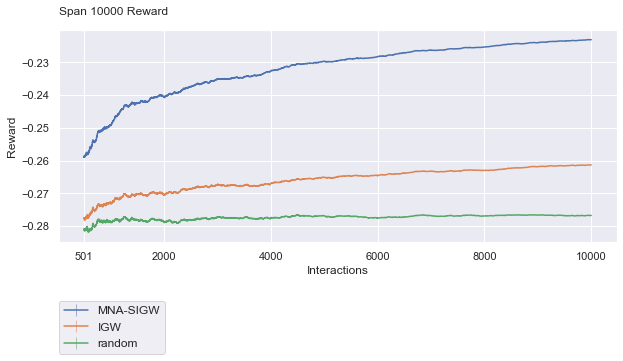

In [9]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = .5 * (np.dot(theta, np.array(context)) + 1)
    h = 0. 
        
    if context[0] > .25:
        h += 0
    else:
        h += -np.max(v)
    

    g = .5 * (v[np.argmax(action)] + np.sin(2*np.pi*v[np.argmax(action)]))
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = True
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)]

os.remove("./data/paper-experiment-6.log")
result = Experiment(environments, learners).evaluate("./data/paper-experiment-6.log")
result.plot_learners(sort="reward", span=n_interactions)

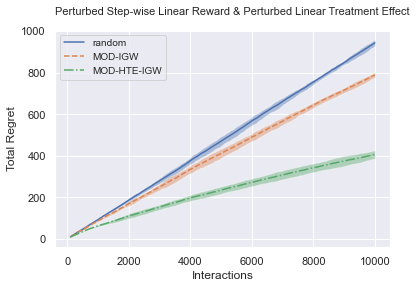

In [9]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-6.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "MOD-IGW", "MOD-HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i%len(ls)])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Perturbed Step-wise Linear Reward & Perturbed Linear Treatment Effect", loc='left', pad=15, fontsize=11)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-6.png', dpi=300)

## Step-wise linear + perturbed linear treatment effect, no model selection

2022-11-30 20:38:18 -- Processing chunk...
2022-11-30 20:38:18 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-11-30 20:38:18 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-11-30 20:38:18 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-11-30 20:38:20 --   * Loading LambdaSimulation... (1.5 seconds) (completed)
2022-11-30 20:38:20 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-11-30 20:38:20 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-11-30 20:38:20 --   * Evaluating Learner 0 on Environment 0... (0.28 seconds) (completed)
2022-11-30 20:38:47 --   * Evaluating Learner 1 on Environment 0... (26.53 seconds) (completed)
2022-11-30 20:39:17 --   * Evaluating Learner 2 on Environment 0... (30.88 seconds) (completed)
2022-11-30 20:39:19 --   * Loading LambdaSimulation... (1.45 seconds) (completed)
2022-11-30 20:39:19 --   * Creating Environment 1 from Lo

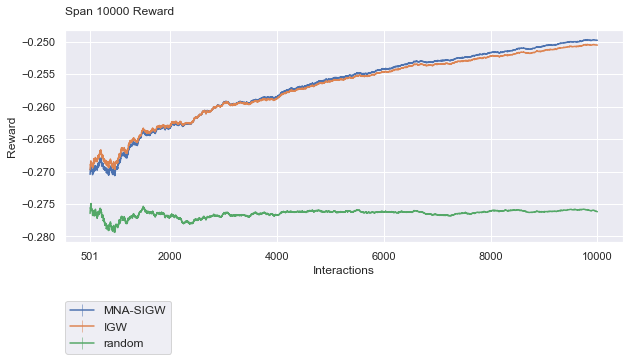

In [11]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = .5 * (np.dot(theta, np.array(context)) + 1)
    h = 0. 
        
    if context[0] > .25:
        h += 0
    else:
        h += -np.max(v)
    

    g = .5 * (v[np.argmax(action)] + np.sin(2*np.pi*v[np.argmax(action)]))
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = False
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)]

os.remove("./data/paper-experiment-7.log")
result = Experiment(environments, learners).evaluate("./data/paper-experiment-7.log")
result.plot_learners(sort="reward", span=n_interactions)

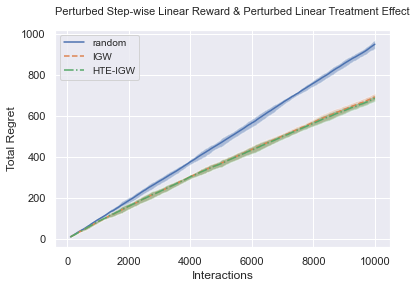

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-7.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "IGW", "HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i%len(ls)])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Perturbed Step-wise Linear Reward & Perturbed Linear Treatment Effect", loc='left', pad=15, fontsize=11)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-7.png', dpi=300)